In [23]:
import gymnasium as gym

from IPython.display import clear_output
from IPython.utils import io
import matplotlib.pyplot as plt
 
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
from collections import deque
import seaborn as sns
import matplotlib.patches as mpatches
import random

In [24]:
# Create the CartPole environment
env = gym.make('CartPole-v1')

# Extract state and action dimensions
state_size = env.observation_space.shape[0]  
action_size = env.action_space.n

In [ ]:
# Hyperparameters   
# This is a good value for the learning rate, not too high or too low
learning_rate = 0.01
# Discount factor for future rewards
gamma = 0.99
# Exploration rate, at the beginning the agent explores a lot.
# start with 1.0, min is 0.015 and decay it to 0.99
epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.015
# Replay buffer size
# I will go with a buffer size of 3000 steps
buffer_size = 1200
# Batch size
batch_size = 64
max_episodes = 500
# 4 steps for between gradient updates
q_model_train_step_interval = 4
# Target network update interval
# Each 128 steps, the target network is updated 
target_step_update_interval = 128

<center><h2>Model architecture</h2></center>

In [ ]:
# For Stabilizing the training, I need a buffer to store the experiences
class ReplayBuffer:
    # Constructor method for the ReplayBuffer class
    # capacity is parameters for the buffer size
    def __init__(self, capacity):
        # I create deque object with a maximum length of capacity
        # When the buffer is full, the oldest experience will be removed
        self.buffer: deque = deque(maxlen=capacity)
        # Store new experiences in the buffer
    def store(self, experience: tuple):
        self.buffer.append(experience)
        
        # batch of experiences, which is a tuple of (state, action, reward, next_state, done)
    def sample(self, batch_size):
        indicate = np.random.choice(len(self.buffer), batch_size, replace=False) 
         # I used replace=False in np.random.choice to avoid duplicate samples in one batch
        batch = [self.buffer[i] for i in indicate]  
        state, action, reward, next_state, done = map(np.array, zip(*batch)) 
        return state, action, reward, next_state, done
    def size(self):
      return len(self.buffer) 
# I got the amin code structure from lecture note,  but I got the deque (double-ended queue) from medium :
# https://medium.com/@heyamit10/deep-reinforcement-learning-with-experience-replay-1222ea711897


In [27]:
# Create the Q-Network and Target Network   
# state_size is the input size, for CartPole it is 4
# action_size : how many possible actions are there, for CartPole it is 2
# In model architecture, there are 2 hidden layers with 24 neurons
# The output layer has 2 neurons, one for each action
def build_q_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(state_size,)),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(24, activation='relu'),
        keras.layers.Dense(action_size, activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    
    return model

q_model = build_q_model()
# create a target model to stabilize the training, I explained why we need target model in another notebook.
target_model = build_q_model()
# Initialize the target model with the q_model weights
target_model.set_weights(q_model.get_weights()) 
replay_buffer = ReplayBuffer(buffer_size) 
q_model.summary()
# I got the main code structure from lecture note

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 24)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 770 (3.01 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

**Training function**

In [ ]:
# For exploration and exploitation, I need a function to select an action:
# state is the current state
def select_action (state, epsilon):
    # Here ia used NumPy function to generate a random number between 0 and 1
    # if the random number is less than epsilon, the agent will take a random action
    if np.random.rand() < epsilon:
        return np.random.choice(action_size)
    # Add a batch dimension to state for compatibility with neural network input
    state = np.expand_dims(state, axis=0)
    with io.capture_output() as captured:
        q_values = q_model.predict(state)
    return np.argmax(q_values)

# I got the function from lecture note

In [ ]:
def train_step():
    # check the replay buffer size
    if replay_buffer.size() < batch_size:
      return
    # sample a batch of experiences from the replay buffer
    states, actions, rewards, next_states, done = replay_buffer.sample(batch_size)
    
    # Q model predicts the q values for the current states
    state_q_values = q_model.predict(states, verbose=0)
    # Target model predicts the q values for the next states
    next_state_q_values = target_model.predict(next_states, verbose=0)
    #  Initialize the targets with the current q values
    targets = state_q_values.copy()
    
    # I use q_model to predict current Q values and target_model for next state predictions.
    # This is a standard trick in DQN to stabilize training. The target model updates less frequently than the main model
    
    for i in range(batch_size):
        if done [i]:
        # if the episode is done, so there is no future rewards
           targets[i, actions[i]] = rewards[i]      
        else:
        # if the episode is not done, so I will calculate the future rewards by using the Bellman equation
           targets[i, actions[i]] = rewards[i] + gamma * np.max(next_state_q_values[i]) 
               
    with io.capture_output() as captured:
        loss = q_model.train_on_batch(states, targets)
    return loss
# How I update the Q values, 
# For each experience in the batch, I update the Q value using the Bellman equation . If the episode ends (done[i] is true), the target is just the reward.
# Otherwise, it becomes reward + gamma * max_future_Q. This follows the Bellman equation's core idea: future rewards matter less than immediate.
# I got the function from lecture note

**Training Loop**

In [ ]:
# For training training process, I define three lists to store the losses, rewards and variances
losses, rewards, variances = [], [], []
# losses: store the loss values for each training step
# rewards: track cumulative rewards for each episode
# variances: store the variance of rewards for each episode
total_steps = 0 

for episode in range(max_episodes):
        state, _ = env.reset()
        total_reward = 0.0

        for _ in range(max_episodes):     
            action = select_action(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)

            # Store transition in the replay buffer
            replay_buffer.store((state, action, reward, next_state, done))
            # Updates the current state to next_state.
            state = next_state
            total_reward += reward
            total_steps += 1
            # Trains the q_model at fixed intervals
            if total_steps % q_model_train_step_interval == 0:
                loss = train_step()
                losses.append(loss)

            # Target Network Update
            if total_steps % target_step_update_interval == 0:
                target_model.set_weights(q_model.get_weights())

            if done:
                break

        # Epsilon decay after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Store the total reward for the episode
        rewards.append(total_reward)
        # Calculate the variance of rewards for the episode
        variances.append(np.var(rewards))
        print(f'Episode {episode + 1} | Reward: {total_reward:.2f} | 'f'Epsilon: {epsilon:.3f} | Steps: {total_steps}')
        # Early stopping condition, CartPole-v1 is solved if the total reward is >= 475
        if total_reward >= 475:
            print(f'Solved in {episode + 1} episodes!')
            break
# Epsilon starts high  and decays over time . This follows standard Q learning practices but, I must ensure epsilon doesn't decay too fast.
# If it does, the agent might not explore enough to find optimal actions.
# store experiences in the replay buffer and train the q_model at q_model_train_step_interval. 
# I calculated reward variance using np.var(rewards), which measures how much the rewards change across episodes.
# I got the code from lecture note

Episode 1 | Reward: 17.00 | Epsilon: 0.990 | Steps: 17
Episode 2 | Reward: 13.00 | Epsilon: 0.980 | Steps: 30
Episode 3 | Reward: 28.00 | Epsilon: 0.970 | Steps: 58
Episode 4 | Reward: 24.00 | Epsilon: 0.961 | Steps: 82
Episode 5 | Reward: 15.00 | Epsilon: 0.951 | Steps: 97
Episode 6 | Reward: 21.00 | Epsilon: 0.941 | Steps: 118
Episode 7 | Reward: 20.00 | Epsilon: 0.932 | Steps: 138
Episode 8 | Reward: 11.00 | Epsilon: 0.923 | Steps: 149
Episode 9 | Reward: 15.00 | Epsilon: 0.914 | Steps: 164
Episode 10 | Reward: 40.00 | Epsilon: 0.904 | Steps: 204
Episode 11 | Reward: 13.00 | Epsilon: 0.895 | Steps: 217
Episode 12 | Reward: 11.00 | Epsilon: 0.886 | Steps: 228
Episode 13 | Reward: 13.00 | Epsilon: 0.878 | Steps: 241
Episode 14 | Reward: 35.00 | Epsilon: 0.869 | Steps: 276
Episode 15 | Reward: 15.00 | Epsilon: 0.860 | Steps: 291
Episode 16 | Reward: 14.00 | Epsilon: 0.851 | Steps: 305
Episode 17 | Reward: 27.00 | Epsilon: 0.843 | Steps: 332
Episode 18 | Reward: 13.00 | Epsilon: 0.835 |

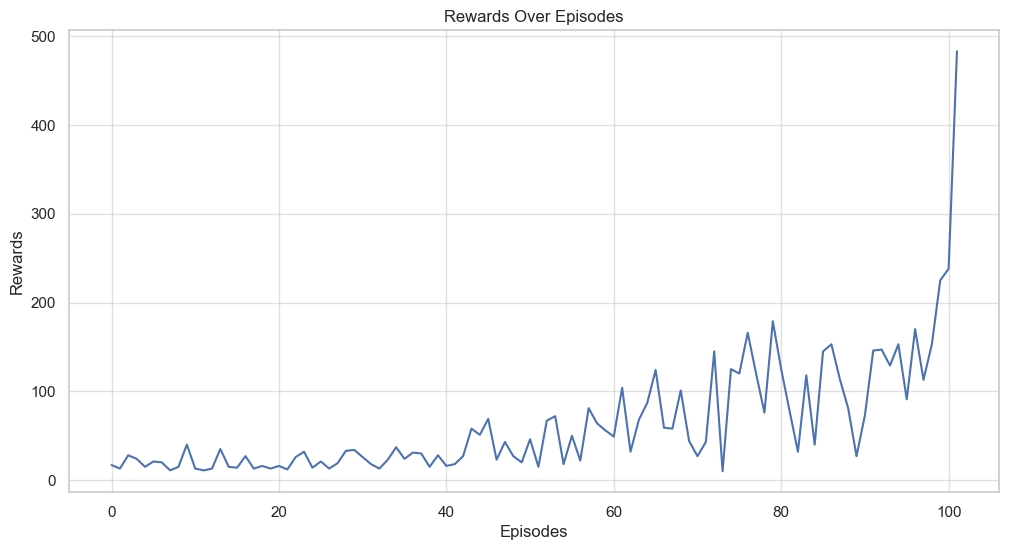

In [ ]:
sns.set_theme(style='whitegrid')  
plt.figure(figsize=(12, 6))
plt.plot(rewards)  
plt.title('Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Rewards')   
plt.grid(alpha=0.6)

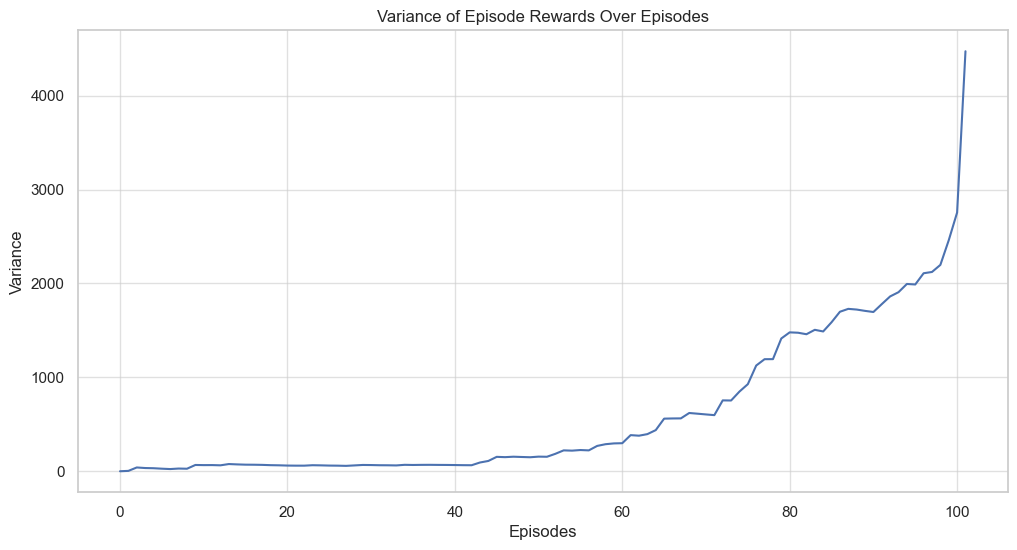

In [ ]:
sns.set_theme(style='whitegrid')  
plt.figure(figsize=(12, 6))
plt.plot(variances)  
plt.title('Variance of Episode Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Variance')   
plt.grid(alpha=0.6)

In [ ]:
# What I can see from both graphs, from 0 to 60 episodes, the rewards curve is close to zero,
# I think it makes sense because the agent is exploring the environment and learning from its experiences and epsilon is 1 

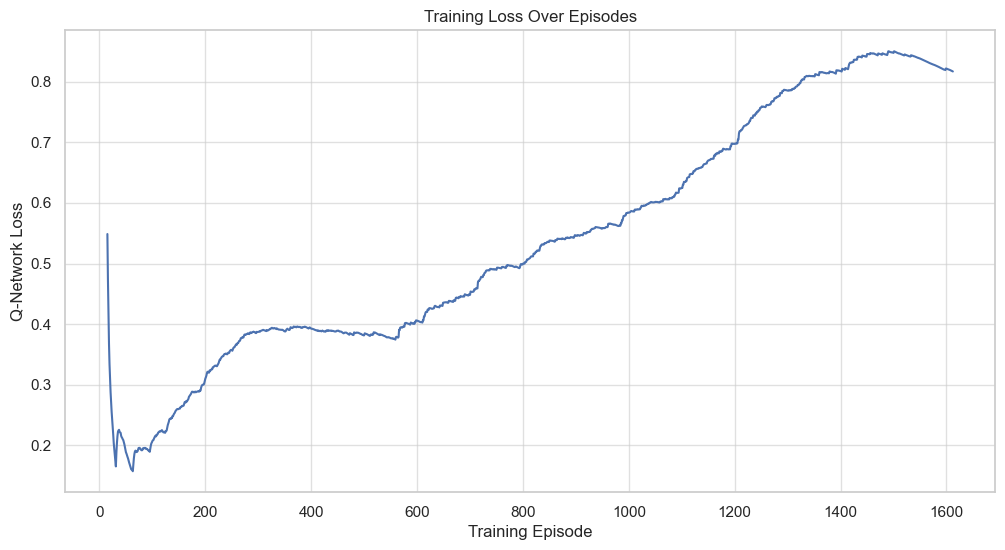

In [36]:
sns.set_theme(style='whitegrid')  
plt.figure(figsize=(12, 6))
plt.plot(losses)  
plt.title('Training Loss Over Episodes')         
plt.xlabel('Training Episode')                  
plt.ylabel('Q-Network Loss')                     
plt.grid(alpha=0.6)  

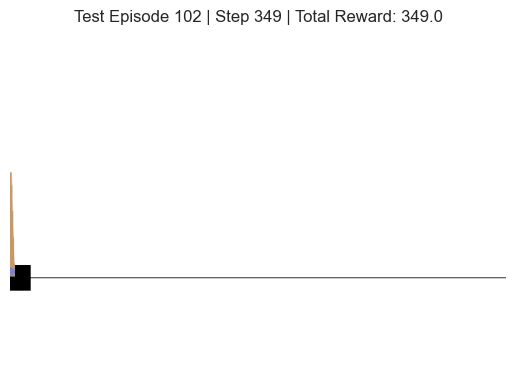

In [37]:
# Testing the Trained Agent
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(1000):
    # Select action
    action = select_action(state, epsilon)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    frame = env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Test Episode {episode+1} | Step {step+1} | Total Reward: {total_reward}')
    plt.pause(0.01)

    if done:
        break

# close the environment
env.close()
plt.close()

# I got the code from lecture note